# Short term flood prediction using LSTM



In [0]:
#Flood Early Warning System using IoT and Edge 
#Eric Samikwa

In [0]:
%matplotlib inline

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import io
import keras
import requests
from matplotlib import pyplot
import matplotlib.patches as mpatches
from numpy import concatenate
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense 
from tensorflow.python.keras.layers import Dropout 
from tensorflow.python.keras.layers import Activation     
from tensorflow.python.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import metrics
from keras.layers import LeakyReLU

# Data pre-processing

In [0]:
# fix random seed for reproducibility
np.random.seed(10)

### Hourly rainfall data

In [0]:
#get hourly rainfall data
df_rain = pandas.read_csv("https://raw.githubusercontent.com/ricsamikwa/short-term-flood-water-level-prediction/master/dataset/new_data/hourly_rainfall_train.csv")

In [595]:
#display first 5
df_rain.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm)
0,2018-12-02 18:00:00,0.0,0.0
1,2018-12-02 17:00:00,0.0,0.0
2,2018-12-02 16:00:00,0.0,0.0
3,2018-12-02 15:00:00,0.0,0.0
4,2018-12-02 14:00:00,0.0,0.0


In [596]:
#dataframe shape
df_rain.shape

(66900, 3)

In [597]:
#dataset properties
df_rain.describe()  


,Current rainfall (mm),Cumulative rainfall (mm)
count,66896.000000,66899.000000
mean,0.043584,0.514999
std,0.724079,2.374298
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,110.000000,56.600000


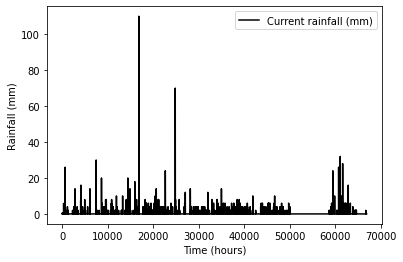

In [598]:

df_rain.plot( y='Current rainfall (mm)', color='black')  

plt.xlabel('Time (hours)')  
plt.ylabel('Rainfall (mm)')  
plt.show()  

### Hourly water level data

In [0]:
#get hourly water level data
df_water_level = pandas.read_csv("https://raw.githubusercontent.com/ricsamikwa/short-term-flood-water-level-prediction/master/dataset/new_data/hourly_water_level_train.csv")

In [600]:
df_water_level.head()

,Date/Time,Level (m)
0,2018-12-02 17:00:00,1.61
1,2018-12-02 16:00:00,1.61
2,2018-12-02 15:00:00,1.62
3,2018-12-02 14:00:00,1.63
4,2018-12-02 13:00:00,1.63


In [601]:
df_water_level.shape

(66890, 2)

In [602]:
#dataset properties
df_water_level.describe()

,Level (m)
count,66890.000000
mean,1.453650
std,0.099223
min,0.000000
25%,1.400000
50%,1.450000
75%,1.500000
max,2.680000


<Figure size 720x504 with 0 Axes>

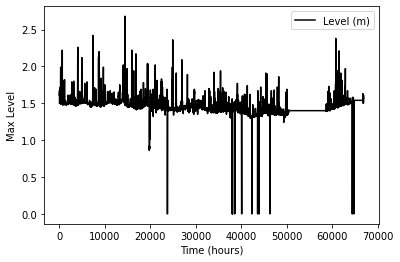

In [603]:
plt.figure(
    figsize=(10, 7))
df_water_level.plot(y='Level (m)', color='black')  
plt.xlabel('Time (hours)')  
plt.ylabel('Max Level')  
plt.show() 

### Combining dataset

In [604]:
#dataset merged on date_time 
dataset = pandas.merge(df_rain, df_water_level, how='outer', on=['Date/Time'])
dataset.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2018-12-02 18:00:00,0.0,0.0,NaN
1,2018-12-02 17:00:00,0.0,0.0,1.61
2,2018-12-02 16:00:00,0.0,0.0,1.61
3,2018-12-02 15:00:00,0.0,0.0,1.62
4,2018-12-02 14:00:00,0.0,0.0,1.63


### Filling missing values

In [605]:
#filling all missing values with mean of the column
dataset['Cumulative rainfall (mm)'] = dataset['Cumulative rainfall (mm)'].fillna(dataset['Cumulative rainfall (mm)'].mean())
dataset['Current rainfall (mm)'] = dataset['Current rainfall (mm)'].fillna(dataset['Current rainfall (mm)'].mean())
dataset['Level (m)'] = dataset['Level (m)'].fillna(dataset['Level (m)'].mean())

dataset.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2018-12-02 18:00:00,0.0,0.0,1.45365
1,2018-12-02 17:00:00,0.0,0.0,1.61000
2,2018-12-02 16:00:00,0.0,0.0,1.61000
3,2018-12-02 15:00:00,0.0,0.0,1.62000
4,2018-12-02 14:00:00,0.0,0.0,1.63000


In [606]:
dataset = dataset.drop(columns=['Cumulative rainfall (mm)', 'Date/Time'])
dataset.shape

(66902, 2)

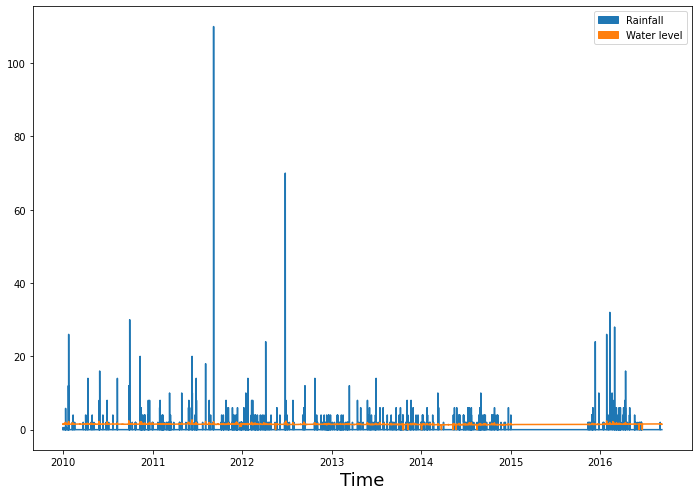

In [607]:
plt.figure(
    figsize=(10, 7))

plt.plot(dataset)
plt.xlabel('Time',fontsize=18)  
plt.tight_layout() 
rainfall = mpatches.Patch(color='C0', label='Rainfall')
level = mpatches.Patch(color='C1', label='Water level')
plt.legend(handles=[rainfall,level])
positions = (0, 10000, 20000, 30000, 40000, 50000, 60000)
labels = ("2010", "2011", "2012", "2013", "2014", "2015", "2016")
plt.xticks(positions, labels)

plt.show() 

### Scaling dataset 

In [0]:
# normalize the dataset (LSTMs are sensitive to the scale of the input data)
scaler  = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

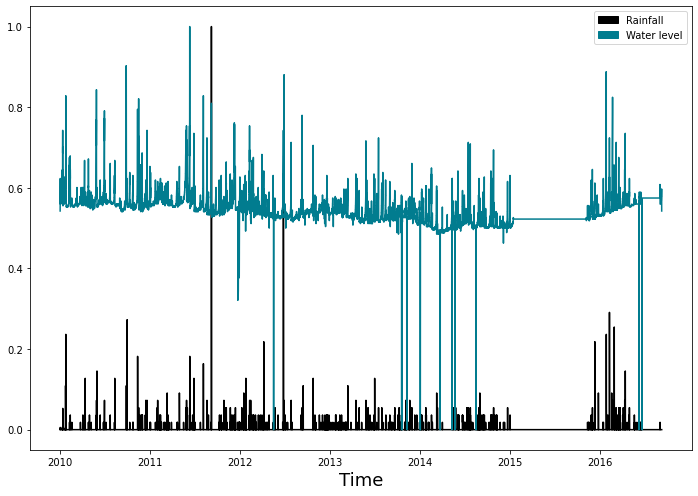

In [609]:
plt.figure(
    figsize=(10, 7))

plt.plot(dataset[:,0], color='black')
plt.plot(dataset[:,1], color='#017C8F')
plt.xlabel('Time',fontsize=18)  
plt.tight_layout() 
rainfall = mpatches.Patch(color='black', label='Rainfall')
level = mpatches.Patch(color='#017C8F', label='Water level')
plt.legend(handles=[rainfall,level])
positions = (0, 10000, 20000, 30000, 40000, 50000, 60000)
labels = ("2010", "2011", "2012", "2013", "2014", "2015", "2016")
plt.xticks(positions, labels)

plt.show() 

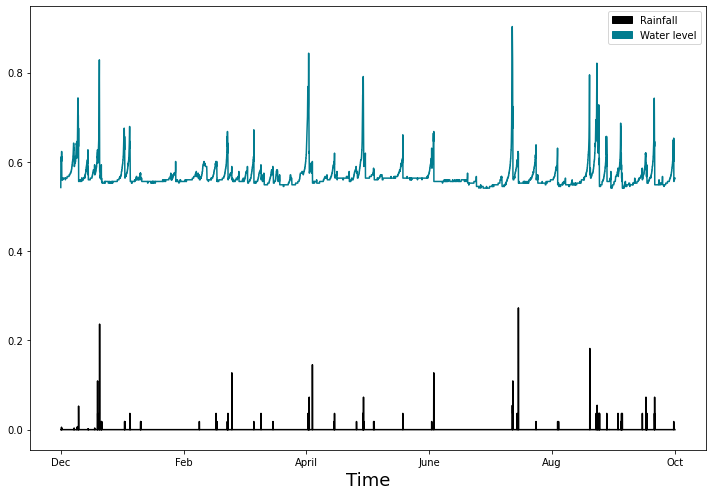

In [610]:
plt.figure(
    figsize=(10, 7))

plt.plot(dataset[0:10000,0], color='black')
plt.plot(dataset[0:10000,1], color='#017C8F')
plt.xlabel('Time', fontsize=18)  
plt.ylabel('') 
plt.tight_layout() 
rainfall = mpatches.Patch(color='black', label='Rainfall')
level = mpatches.Patch(color='#017C8F', label='Water level')
plt.legend(handles=[rainfall,level])
positions = (0, 2000, 4000, 6000, 8000, 10000)
labels = ("Dec", "Feb", "April", "June", "Aug", "Oct")
plt.xticks(positions, labels)
plt.show() 

# Training 

#### Dataset sliding window (Multivariate)

In [0]:
# structure data for lstm forecasting with multivariate input
def create_multivariate_LSTM_form(sensor_data_sequence, num_past_hours=1, num_predictions=1):
    
	num_features = sensor_data_sequence.shape[1]

	sensor_data_sequence_df = pandas.DataFrame(sensor_data_sequence)
	columns, names = list(), list()
 
	# past data to be observed for each prediction, i.e. input sequence (t-10, ... t-1)
	for n in range(num_past_hours, 0, -1):

		columns.append(sensor_data_sequence_df.shift(n))
		names += [('var%d(t-%d)' % (m+1, n)) for m in range(num_features)]

	# specifying the predicted output sequence i.e. (t,t+1, ...., t+10)
  # output is (t+10) in this case
	for n in range(0, num_predictions):
		columns.append(sensor_data_sequence_df.shift(-n))
		if n == 0:
			names += [('var%d(t)' % (m+1)) for m in range(num_features)]
		else:
			names += [('var%d(t+%d)' % (m+1, n)) for m in range(num_features)]

	# combine all columns and remove NaN values
	combined_data = pandas.concat(columns, axis=1)
	combined_data.columns = names
	combined_data.dropna(inplace=True)

	return combined_data

In [612]:
#number of hours to be observed when making a each forecast
num_hours = 10
pred_window = 10

#number of features observed
num_features = 2

# frame data as supervised learning
reframed_data = create_multivariate_LSTM_form(dataset, num_hours,pred_window)
print(reframed_data.shape)

(66883, 40)


#### Spliting data to training and test set

In [0]:
# split into train, validation and test sets (70%, 15%, 15%)
values = reframed_data.values

num_train_hours = 55100 # approx 70% of the dataset


#separated datasets
train = values[:num_train_hours, :]
validate= values[num_train_hours:, :]

In [614]:
#training data shape
print(train.shape)

#test data shape
print(validate.shape)

(55100, 40)
(11783, 40)


In [615]:
# specifying inputs and outputs
num_obs = num_hours * num_features
#traning set
trainX, trainY = train[:, :num_obs], train[:, -1]
#validation set
validateX, validateY = validate[:, :num_obs], validate[:, -1]
print(trainX.shape, len(trainX), trainY.shape)

(55100, 20) 55100 (55100,)


In [616]:
print(trainY[1])

0.5597014925373134


#### Reshaping to LSTM input format

In [617]:
# reshape data correctly to reflect the time steps and features [samples, timesteps, features]
trainX = trainX.reshape((trainX.shape[0], num_hours, num_features))

validateX = validateX.reshape((validateX.shape[0], num_hours, num_features))
print(trainX.shape, trainY.shape, validateX.shape, validateY.shape)

(55100, 10, 2) (55100,) (11783, 10, 2) (11783,)


In [662]:
#forecast points check
print(trainX[9])
print(trainY[0])

[[0.         0.60820896]
 [0.         0.60820896]
 [0.         0.6119403 ]
 [0.00545455 0.60074627]
 [0.         0.61567164]
 [0.         0.62313433]
 [0.         0.58208955]
 [0.00181818 0.55970149]
 [0.         0.55970149]
 [0.         0.55970149]]
0.5597014925373134


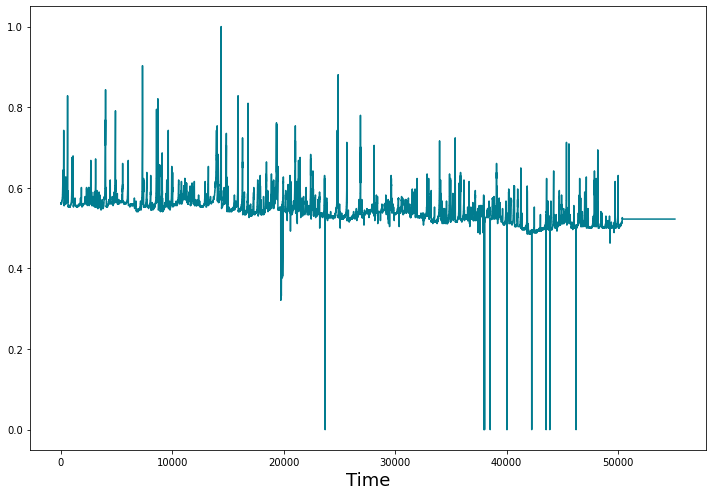

In [619]:
plt.figure(
    figsize=(10, 7))

plt.plot(trainY, color='#017C8F')
plt.xlabel('Time', fontsize=18)  
plt.ylabel('') 
plt.tight_layout() 

plt.show() 

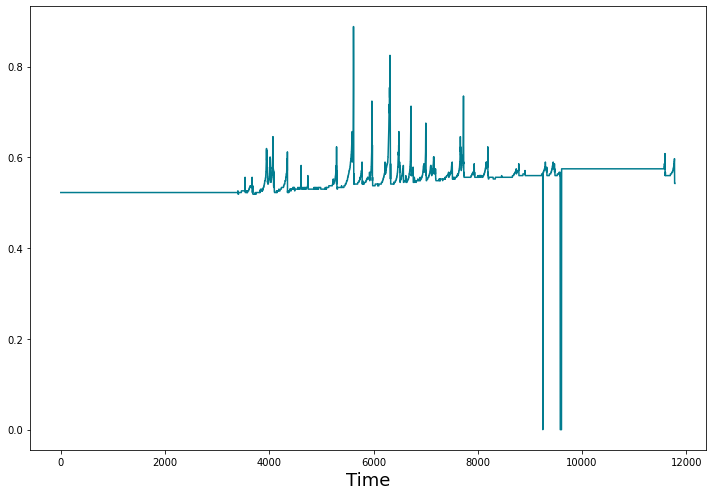

In [620]:
plt.figure(
    figsize=(10, 7))

plt.plot(validateY, color='#017C8F')
plt.xlabel('Time', fontsize=18)  
plt.ylabel('') 
plt.tight_layout() 

plt.show()

## Model (LSTM)

In [0]:
#Setup the LSTM model (with multivariate input)

model = Sequential()
model.add(LSTM(30, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [622]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30)                3960      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 31        
Total params: 3,991
Trainable params: 3,991
Non-trainable params: 0
_________________________________________________________________


## Model Learning

### training and validation

In [0]:
callback = EarlyStopping(monitor='val_loss', mode='min',verbose=1,patience=30, baseline=0.000073750)

In [624]:
#training :  epochs and batch size 64
history = model.fit(trainX, trainY, epochs=200, batch_size=64, callbacks=[callback],
                    validation_data=(validateX, validateY), shuffle=False)

Epoch 1/200
861/861 [==============================] - 5s 6ms/step - loss: 0.0070 - val_loss: 8.5473e-04
Epoch 2/200
861/861 [==============================] - 5s 6ms/step - loss: 6.3188e-04 - val_loss: 8.6017e-04
Epoch 3/200
861/861 [==============================] - 5s 6ms/step - loss: 6.5018e-04 - val_loss: 8.7533e-04
Epoch 4/200
861/861 [==============================] - 5s 6ms/step - loss: 6.6181e-04 - val_loss: 8.8118e-04
Epoch 5/200
861/861 [==============================] - 5s 6ms/step - loss: 6.5208e-04 - val_loss: 8.8703e-04
Epoch 6/200
861/861 [==============================] - 5s 6ms/step - loss: 6.5426e-04 - val_loss: 8.7201e-04
Epoch 7/200
861/861 [==============================] - 5s 6ms/step - loss: 6.4292e-04 - val_loss: 8.7113e-04
Epoch 8/200
861/861 [==============================] - 5s 6ms/step - loss: 6.3666e-04 - val_loss: 8.6719e-04
Epoch 9/200
861/861 [==============================] - 5s 6ms/step - loss: 6.3701e-04 - val_loss: 8.5435e-04
Epoch 10/200
861/861 [=

###training performance

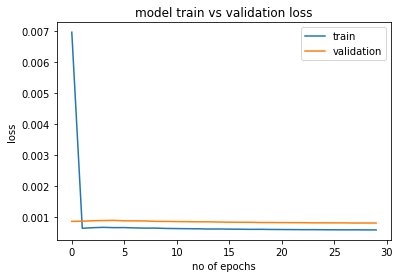

In [625]:
# plot loss during training
pyplot.plot(history.history['loss'], label='training')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.title('model train vs validation loss')
plt.xlabel('no of epochs')  
plt.ylabel('loss') 
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [626]:
# model RMSE
train_score = model.evaluate(trainX, trainY, verbose=1)
train_score = math.sqrt(train_score)

validation_score = model.evaluate(validateX, validateY, verbose=1)
validation_score = math.sqrt(validation_score)
print('Train Score: %.2f %% RMSE' % (train_score*100))
print('Validation Score: %.2f %% RMSE' % (validation_score*100))

369/369 [==============================] - 1s 2ms/step - loss: 8.0121e-04
Train Score: 2.51 % RMSE
Validation Score: 2.83 % RMSE


In [0]:
model.save('my_model.h5') 

In [628]:
# Convert the model.
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
converter.allow_custom_ops=True
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

29892

# Testing

###Test Data Preprocessing

In [0]:
#Same point

df_rain_test = pandas.read_csv("https://raw.githubusercontent.com/ricsamikwa/short-term-flood-water-level-prediction/master/dataset/new_data/hourly_rainfall_test.csv")
df_water_level_test = pandas.read_csv("https://raw.githubusercontent.com/ricsamikwa/short-term-flood-water-level-prediction/master/dataset/new_data/hourly_water_level_test.csv")

#Another point

# df_rain_test = pandas.read_csv("https://raw.githubusercontent.com/ricsamikwa/short-term-flood-water-level-prediction/master/dataset/new_data/Elsternwick-Hourly-Rainfall.csv")
# df_water_level_test = pandas.read_csv("https://raw.githubusercontent.com/ricsamikwa/short-term-flood-water-level-prediction/master/dataset/new_data/Elsternwick-Hourly-River-Level.csv")

In [630]:
#dataset merged on date_time 
dataset_test = pandas.merge(df_rain_test, df_water_level_test, how='outer', on=['Date/Time'])
dataset_test.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2011-04-07 20:00:00,0.0,0.0,1.49
1,2011-04-07 19:00:00,0.0,0.0,1.49
2,2011-04-07 18:00:00,0.0,0.0,1.49
3,2011-04-07 17:00:00,0.0,0.0,1.49
4,2011-04-07 16:00:00,0.0,0.0,1.49


In [631]:
dataset_test.describe()

,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
count,11828.000000,11828.000000,11812.000000
mean,0.077951,0.976243,1.452874
std,0.957547,4.348222,0.174743
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.400000
50%,0.000000,0.000000,1.440000
75%,0.000000,0.200000,1.500000
max,64.000000,111.400000,3.300000


In [632]:
#filling all missing values with mean of the column
dataset_test['Cumulative rainfall (mm)'] = dataset_test['Cumulative rainfall (mm)'].fillna(dataset_test['Cumulative rainfall (mm)'].mean())
dataset_test['Current rainfall (mm)'] = dataset_test['Current rainfall (mm)'].fillna(dataset_test['Current rainfall (mm)'].mean())
dataset_test['Level (m)'] = dataset_test['Level (m)'].fillna(dataset_test['Level (m)'].mean())

dataset_test.head()

,Date/Time,Current rainfall (mm),Cumulative rainfall (mm),Level (m)
0,2011-04-07 20:00:00,0.0,0.0,1.49
1,2011-04-07 19:00:00,0.0,0.0,1.49
2,2011-04-07 18:00:00,0.0,0.0,1.49
3,2011-04-07 17:00:00,0.0,0.0,1.49
4,2011-04-07 16:00:00,0.0,0.0,1.49


In [633]:
dataset_test = dataset_test.drop(columns=['Cumulative rainfall (mm)', 'Date/Time'])
dataset_test.shape

(11836, 2)

In [0]:
waterlelvels = dataset_test['Level (m)']


In [635]:
# true_waterlelvels = waterlelvels[1019:11955]
true_waterlelvels = waterlelvels[0:11825]
[11817, 11825]
print(true_waterlelvels.shape)


(11825,)


In [0]:
# normalize the dataset (LSTMs are sensitive to the scale of the input data)
# scaler  = MinMaxScaler(feature_range=(0, 1))
dataset_test = scaler.fit_transform(dataset_test)

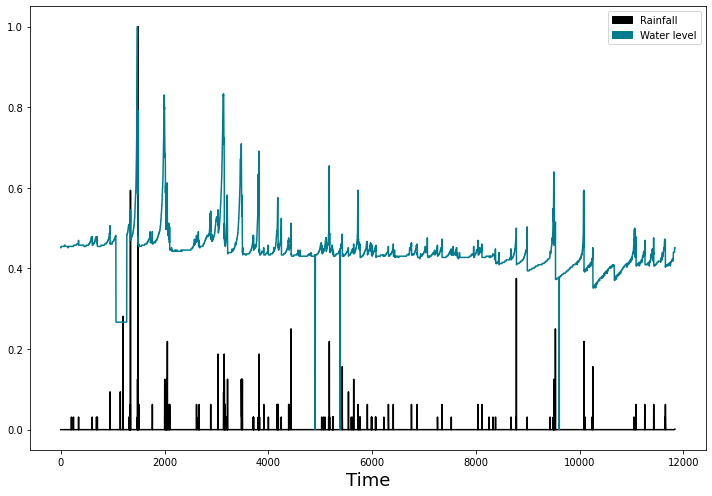

In [637]:
plt.figure(
    figsize=(10, 7))

plt.plot(dataset_test[:,0], color='black')
plt.plot(dataset_test[:,1], color='#017C8F')
plt.xlabel('Time',fontsize=18)  
plt.tight_layout() 
rainfall = mpatches.Patch(color='black', label='Rainfall')
level = mpatches.Patch(color='#017C8F', label='Water level')
plt.legend(handles=[rainfall,level])

plt.show() 

In [638]:
# frame data as supervised learning
reframed_data_test = create_multivariate_LSTM_form(dataset_test, num_hours, pred_window)
print(reframed_data_test.shape)

(11817, 40)


In [0]:
# split into train, validation and test sets (70%, 15%, 15%)
test = reframed_data_test.values


In [0]:

#testing set
testX, testY = test[:, :num_obs], test[:, -1]


In [641]:
# reshape data correctly to reflect the time steps and features [samples, timesteps, features]
testX = testX.reshape((testX.shape[0], num_hours, num_features))

print(testX.shape, testY.shape)

(11817, 10, 2) (11817,)


In [642]:
print(testY[0])
print(testY[1])

0.4545454545454546
0.4545454545454546


### predictions using unseen test data 
#### 10 hours ahead of time prediction







In [0]:
# predictions
predictions = model.predict(testX)
unseen_X = testX.reshape((testX.shape[0], num_hours*num_features))

In [0]:
# invert scaling for predicted water levels
inv_predictions = concatenate((unseen_X[:,-1:],predictions), axis=1)

inv_predictions = scaler.inverse_transform(inv_predictions)

inv_predictions = inv_predictions[:,1]

In [645]:
print(predictions[0])
print(inv_predictions[0])

[0.47667402]
1.5730242669582366


In [646]:
# invert scaling for actual water levels 
testY = testY.reshape((len(testY), 1))
inv_waterlelvels = concatenate((unseen_X[:, -1:],testY), axis=1)
print(inv_waterlelvels[10000])
inv_waterlelvels = scaler.inverse_transform(inv_waterlelvels)
inv_waterlelvels = inv_waterlelvels[:,1]

[0.42424242 0.42424242]


In [647]:
print(inv_waterlelvels[0])

1.5


###predictions vs ground truth

----------------- Predicted ---------------


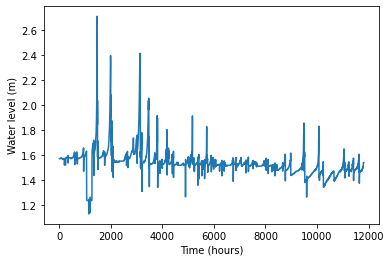

----------------- Ground Truth ---------------


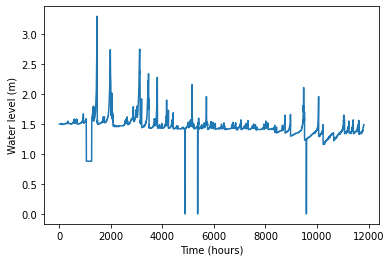

In [648]:
print('----------------- Predicted ---------------')
plt.plot(inv_predictions)
plt.xlabel('Time (hours)')  
plt.ylabel('Water level (m)') 
plt.show()
print('----------------- Ground Truth ---------------')
plt.plot(inv_waterlelvels)
plt.xlabel('Time (hours)')  
plt.ylabel('Water level (m)') 
plt.show()

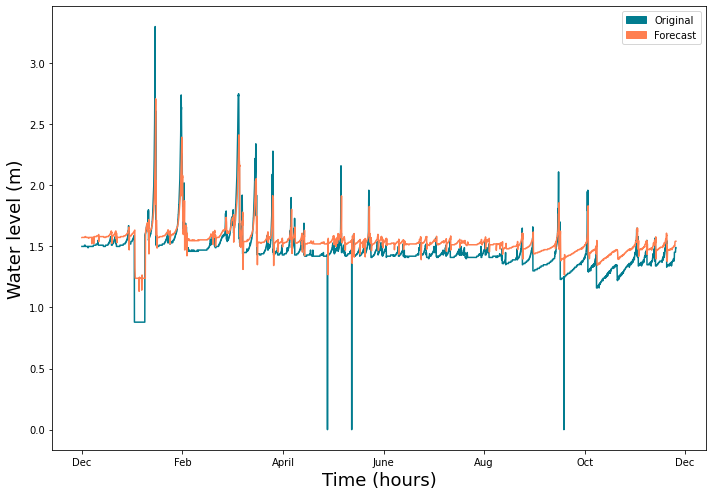

In [649]:
plt.figure(
    figsize=(10, 7))
plt.plot(inv_waterlelvels, color='#017C8F')
plt.plot(inv_predictions, color='coral')
plt.xlabel('Time (hours)', fontsize=18)  
plt.ylabel('Water level (m)', fontsize=18) 
plt.tight_layout() 
Original = mpatches.Patch(color='#017C8F', label='Original')
Forecast = mpatches.Patch(color='coral', label='Forecast')
plt.legend(handles=[Original,Forecast])
positions = (0, 2000, 4000, 6000, 8000, 10000,12000)
labels = ("Dec", "Feb", "April", "June", "Aug", "Oct","Dec")
plt.xticks(positions, labels)
plt.show() 

#Performance Evaluation
###model performance on unseen data



In [650]:
# root mean squared error (RMSE)
rmse = sqrt(mean_squared_error(inv_waterlelvels, inv_predictions))
print('Test RMSE: %.3f  ' % (rmse))
print('Test RMSE: %.3f %% ' % ((rmse/3.3)*100))

Test RMSE: 0.128  
Test RMSE: 3.872 % 


In [651]:
# Mean absolute error
mae = keras.metrics.mean_absolute_error(inv_waterlelvels, inv_predictions)
print(mae)

tf.Tensor(0.10382875, shape=(), dtype=float32)


In [652]:
# R Squared
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.truediv(residual, total))
  return r2

print('R^2 score is: ', R_squared(inv_waterlelvels, inv_predictions)) # 0.57142866


R^2 score is:  tf.Tensor(0.4649368460072011, shape=(), dtype=float64)


#Demo

In [0]:
# this section emulates the steps for processing and predicting a flood occurency from sensor data
# realtime_data is the array containing sensor data in this case
# a flood occurancy is likely when the predicted water level exceeds 1.5 m (according to the dataset)

In [654]:
#10 hours historical data (sensor data)
realtime_data = {'rainfall (mm)': [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.9,0.8,0.9],
        'Level (m)': [0.34051556,0.44051556,0.44051556,0.42424242,0.42424242,0.42624242,0.42424242,0.42424242,0.42424242,0.42424242,0.42424242]
        }
demo_df = pandas.DataFrame(realtime_data, columns = ['rainfall (mm)', 'Level (m)'])

print (demo_df.head())

   rainfall (mm)  Level (m)
0            0.0   0.340516
1            0.0   0.440516
2            0.0   0.440516
3            0.0   0.424242
4            0.0   0.424242


In [0]:
#scaling data 
#scaler  = MinMaxScaler(feature_range=(0, 1))
#demo_dataset = scaler.fit_transform(demo_df)

In [656]:
#reframe
demo_data = demo_df.to_numpy()
#demo_data = concatenate((demo_data, demo_data,demo_data), axis=1)
print(demo_data.shape)
reframed_data = create_multivariate_LSTM_form(demo_data, num_hours, 1)
reframed_data = reframed_data.values
reframed_data = reframed_data[:,:20]
print(reframed_data.shape)

(11, 2)
(1, 20)


In [0]:
#reshaping
reframed_data = reframed_data.reshape((reframed_data.shape[0], num_hours, num_features))
# print(reframed_data.shape)

In [658]:
#make prediction (10 hours ahead of time)
predicted_waterlevel = model.predict(reframed_data)

print(predicted_waterlevel)

[[0.4180262]]


In [659]:
print(true_waterlelvels.max())

3.3


In [660]:
# invert scaling for forecast
inv_predicted_waterlevel = predicted_waterlevel[0][0] * true_waterlelvels.max()
print(inv_predicted_waterlevel)

1.3794864892959593


In [661]:
#@title Flood possibility

print('Expected water level in 10 hours is %.3f m' % inv_predicted_waterlevel )

#based on the dataset it is likely to flood when predicted water level exceeds 1.5 m
if (inv_predicted_waterlevel > 1.5):
  print("FLOOD")
else:
  print("No FLOOD")

Expected water level in 10 hours is 1.379 m
No FLOOD
